In [1]:
import ee
import geemap
from geemap import ml
from sklearn import ensemble
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Inicializa la autenticación y la inicialización de Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-facuboladerasgee')

In [2]:
import os

def combine_csv_files(folder_path):
    # Lista para almacenar todos los DataFrames
    df_list = []
    
    # Recorrer todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Leer cada archivo CSV y agregarlo a la lista
            df = pd.read_csv(file_path)
            df_list.append(df)
    
    # Combinar todos los DataFrames en uno solo
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Ejemplo de uso
folder_path = 'C://Users//Facu//Downloads//EarthEngine'
combined_df = combine_csv_files(folder_path)
combined_df.to_csv("RF_nepal_data.csv", index=False)

In [71]:
# Calcular la nueva columna 'threshold'
# Calcular la nueva columna 'threshold'
combined_df['threshold'] = (combined_df['agbd_se'] / combined_df['agbd']) * 100
# combined_df = combined_df.loc[combined_df['Slope'] <= 25]

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11855 entries, 0 to 11854
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  11855 non-null  int64  
 1   B11           11855 non-null  float64
 2   B12           11855 non-null  float64
 3   B2            11855 non-null  float64
 4   B3            11855 non-null  float64
 5   B4            11855 non-null  float64
 6   CH            11855 non-null  float64
 7   MNDWI         11855 non-null  float64
 8   NDBI          11855 non-null  float64
 9   NDVI          11855 non-null  float64
 10  RVI           11855 non-null  float64
 11  VH            11855 non-null  float64
 12  VV            11855 non-null  float64
 13  VV_VH_div_2   11855 non-null  float64
 14  VV_div_VH     11855 non-null  float64
 15  VV_minus_VH   11855 non-null  float64
 16  VV_plus_VH    11855 non-null  float64
 17  agbd          11855 non-null  float64
 18  agbd_se       11855 non-nu

In [72]:
# Filtrar los datos cuyo valor en la columna 'threshold' sea menor que 50
df_filtered = combined_df[combined_df['threshold'] < 50]

# Mostrar las primeras filas del DataFrame filtrado para verificar
df_filtered.describe()

,system:index,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,...,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,label,slope,threshold
count,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,...,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000,2663.000000
mean,527.110026,1979.371386,1129.749718,406.157529,641.087308,524.054262,16.176493,-0.514982,-0.116156,0.658809,...,-12.067641,0.568210,6.624625,-24.135283,73.891930,17.097023,200.514082,1.386219,5.045629,29.877280
std,335.115974,363.723115,385.940609,151.299786,188.847073,259.718707,4.772159,0.052998,0.094445,0.124266,...,0.863737,0.037815,0.508777,1.727474,47.666439,0.667442,68.232227,1.174648,6.183449,12.243307
min,0.000000,678.000000,449.000000,173.000000,304.000000,193.000000,1.000000,-0.638227,-0.358459,0.009205,...,-16.550133,0.400368,4.898447,-33.100266,11.500147,2.985144,97.000000,0.000000,0.000000,1.321927
25%,267.000000,1745.000000,886.250000,324.500000,533.000000,369.000000,13.000000,-0.548161,-0.181543,0.607755,...,-12.510742,0.538591,6.323347,-25.021484,42.249603,17.124998,158.000000,1.000000,2.076554,20.171876
50%,464.000000,1911.500000,1023.500000,368.500000,601.000000,444.500000,16.000000,-0.518008,-0.126268,0.694770,...,-11.910521,0.564936,6.651831,-23.821043,56.006973,17.128124,190.000000,1.000000,2.968213,30.477180
75%,749.000000,2164.500000,1282.750000,435.000000,689.000000,585.250000,19.500000,-0.488033,-0.053480,0.743392,...,-11.451445,0.593550,6.969292,-22.902890,84.888492,17.130884,226.000000,1.000000,5.070520,40.484793
max,1517.000000,3742.000000,3311.000000,1679.000000,2197.000000,2414.000000,28.000000,0.057024,0.194830,0.849204,...,-8.606280,0.691812,9.156950,-17.212560,600.002140,17.172379,559.000000,7.000000,45.936745,49.986630


In [73]:
def remove_outliers(df, column_name):

    # Calcular la media y la desviación estándar de la columna
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    
    # Calcular el umbral para identificar los outliers
    threshold = 3 * std_dev
    
    # Crear una condición para filtrar los outliers
    condition = (df[column_name] >= (mean - threshold)) & (df[column_name] <= (mean + threshold))
    
    # Crear un nuevo DataFrame con los outliers eliminados
    df_filtered = df[condition]
    
    return df_filtered

# Ejemplo de uso
# Supongamos que tienes un DataFrame llamado df_combined con una columna "agbd"
# df_combined = pd.read_csv("ruta_a_tu_csv.csv")

df_filtered_remove = remove_outliers(df_filtered, "agbd")

# Mostrar las primeras filas del DataFrame filtrado
df_filtered_remove.describe()

,system:index,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,...,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,label,slope,threshold
count,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,...,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000
mean,528.218858,1984.416443,1135.345151,407.667880,642.893254,526.799540,16.039862,-0.514932,-0.114623,0.657251,...,-12.083329,0.568811,6.621991,-24.166658,70.142482,17.107157,198.986202,1.394212,4.955001,30.357653
std,336.704204,364.524523,387.165245,152.263797,189.967299,261.325143,4.712105,0.053312,0.094232,0.124763,...,0.859981,0.037585,0.509867,1.719962,39.570516,0.553517,66.222950,1.185418,5.961213,11.898744
min,0.000000,678.000000,450.000000,173.000000,325.000000,193.000000,1.000000,-0.638227,-0.358459,0.009205,...,-16.550133,0.400368,4.898447,-33.100266,11.500147,2.985144,97.000000,0.000000,0.000000,7.939458
25%,266.000000,1747.000000,891.000000,325.000000,533.500000,369.500000,13.000000,-0.548298,-0.179245,0.607010,...,-12.527576,0.538875,6.316329,-25.055153,42.125290,17.125170,157.000000,1.000000,2.076539,20.949703
50%,465.000000,1916.500000,1030.000000,370.000000,602.000000,448.000000,16.000000,-0.518064,-0.124930,0.693182,...,-11.920871,0.565857,6.648669,-23.841742,55.024254,17.128159,189.000000,1.000000,2.968159,31.145018
75%,755.000000,2167.000000,1289.000000,436.000000,691.000000,588.500000,19.000000,-0.487951,-0.052632,0.742967,...,-11.464575,0.594298,6.969454,-22.929150,81.734590,17.130936,225.000000,1.000000,5.070516,40.643190
max,1517.000000,3742.000000,3311.000000,1679.000000,2197.000000,2414.000000,28.000000,0.057024,0.194830,0.849204,...,-8.606280,0.691812,9.156950,-17.212560,215.672350,17.172379,559.000000,7.000000,44.443680,49.986630


In [74]:
df_nuevo = df_filtered_remove[df_filtered_remove['agbd'] <= 180]
df_nuevo.info()
label = df_nuevo['agbd']

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 57 to 11852
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  2525 non-null   int64  
 1   B11           2525 non-null   float64
 2   B12           2525 non-null   float64
 3   B2            2525 non-null   float64
 4   B3            2525 non-null   float64
 5   B4            2525 non-null   float64
 6   CH            2525 non-null   float64
 7   MNDWI         2525 non-null   float64
 8   NDBI          2525 non-null   float64
 9   NDVI          2525 non-null   float64
 10  RVI           2525 non-null   float64
 11  VH            2525 non-null   float64
 12  VV            2525 non-null   float64
 13  VV_VH_div_2   2525 non-null   float64
 14  VV_div_VH     2525 non-null   float64
 15  VV_minus_VH   2525 non-null   float64
 16  VV_plus_VH    2525 non-null   float64
 17  agbd          2525 non-null   float64
 18  agbd_se       2525 non-null   f

In [20]:
# df_proces = df_filtered_remove[~df_filtered_remove['label'].isin([2, 6])]
# df_proces

In [75]:
def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

columns_to_drop = ['threshold', 'agbd_se','.geo','label', 'system:index']
df_modified = drop_columns(df_nuevo, columns_to_drop)
df_modified

,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,RVI,VH,VV,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,agbd,elevation,slope
57,1675.0,829.0,352.0,568.0,350.0,16.0,-0.493535,-0.234461,0.770567,2.597778,-14.833056,-8.006552,-11.419804,0.539778,6.826505,-22.839607,34.270410,145.0,1.393332
58,1675.0,829.0,352.0,568.0,350.0,15.0,-0.493535,-0.234461,0.770567,2.533667,-14.964567,-8.660582,-11.812574,0.578739,6.303986,-23.625149,34.270410,145.0,1.393332
65,1504.0,706.0,295.0,506.0,292.0,16.0,-0.496517,-0.314806,0.816237,2.556014,-14.848450,-8.388433,-11.618441,0.564936,6.460018,-23.236881,34.270410,145.0,1.040033
66,1738.0,880.0,334.0,553.0,341.0,15.0,-0.517241,-0.212862,0.774097,2.526451,-15.064024,-8.786072,-11.925048,0.583249,6.277952,-23.850096,34.270410,145.0,1.040033
69,1804.0,1018.0,436.0,691.0,517.0,14.0,-0.446092,-0.245819,0.704318,2.560645,-15.174340,-8.529592,-11.851966,0.562106,6.644749,-23.703932,54.463364,144.0,1.393336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11846,1885.0,948.0,324.5,533.5,321.5,17.0,-0.558817,-0.155561,0.778352,2.571889,-15.346921,-8.521792,-11.934357,0.555277,6.825129,-23.868713,45.334133,226.0,16.093378
11848,2115.0,1191.5,390.5,645.5,507.5,9.0,-0.532331,-0.166667,0.707366,2.541012,-14.968090,-8.594316,-11.781203,0.574176,6.373774,-23.562407,77.359140,265.0,24.000710
11849,2211.0,1358.0,388.5,650.0,571.0,9.0,-0.545613,-0.047291,0.619524,2.594995,-14.692746,-7.955078,-11.323913,0.541429,6.737668,-22.647825,77.359140,265.0,24.000710
11851,1496.0,786.0,242.0,424.0,215.0,18.0,-0.558333,-0.106199,0.791919,2.546872,-15.087874,-8.608447,-11.848161,0.570554,6.479427,-23.696321,45.334133,230.0,17.452192


In [76]:
# Obtener los nombres de las columnas excepto 'agbd' y '.geo'
features = [col for col in df_modified.columns if col not in ['agbd', 'label','.geo', 'system:index']]

# Mostrar la lista de características
print(features)

['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']


In [77]:
features =  ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']



df_modified_2 = df_modified[features]
df_modified_2.describe()


,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,RVI,VH,VV,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,elevation,slope
count,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,1992.588911,1143.661782,409.902970,646.052673,531.160792,15.826931,-0.514721,-0.112152,0.654773,2.550388,-15.410218,-8.787968,-12.099093,0.569272,6.622251,-24.198186,197.908911,4.895634
std,365.590868,389.277557,153.851769,191.640465,263.868640,4.606177,0.053704,0.094142,0.125602,0.060397,0.854058,0.918967,0.849810,0.037307,0.509040,1.699620,64.961616,5.747822
min,678.000000,450.000000,186.500000,347.000000,205.000000,1.000000,-0.638227,-0.358459,0.009205,2.364329,-20.858124,-12.242143,-16.550133,0.400368,4.898447,-33.100266,97.000000,0.000000
25%,1752.000000,896.500000,326.500000,536.000000,372.000000,13.000000,-0.548298,-0.176551,0.603645,2.508728,-15.799614,-9.354531,-12.538710,0.539548,6.313238,-25.077420,156.000000,1.854334
50%,1927.000000,1044.000000,371.000000,604.000000,452.000000,16.000000,-0.518000,-0.122863,0.691502,2.552887,-15.260489,-8.650641,-11.934357,0.566853,6.643483,-23.868713,187.000000,2.968159
75%,2182.500000,1299.000000,439.000000,695.000000,598.000000,19.000000,-0.487881,-0.049244,0.741456,2.598166,-14.879529,-8.102774,-11.490049,0.594434,6.974927,-22.980099,225.000000,5.070520
max,3742.000000,3311.000000,1679.000000,2197.000000,2414.000000,28.000000,0.057024,0.194830,0.849204,2.856393,-12.291458,-4.921102,-8.606280,0.691812,9.156950,-17.212560,559.000000,39.254787


In [78]:
# Separar la variable objetivo 'agbd'
y = df_modified['agbd']

# Separar las variables independientes (todas excepto 'agbd' y '.geo')
X = df_modified.drop(columns=['agbd'])

X

,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,RVI,VH,VV,VV_VH_div_2,VV_div_VH,VV_minus_VH,VV_plus_VH,elevation,slope
57,1675.0,829.0,352.0,568.0,350.0,16.0,-0.493535,-0.234461,0.770567,2.597778,-14.833056,-8.006552,-11.419804,0.539778,6.826505,-22.839607,145.0,1.393332
58,1675.0,829.0,352.0,568.0,350.0,15.0,-0.493535,-0.234461,0.770567,2.533667,-14.964567,-8.660582,-11.812574,0.578739,6.303986,-23.625149,145.0,1.393332
65,1504.0,706.0,295.0,506.0,292.0,16.0,-0.496517,-0.314806,0.816237,2.556014,-14.848450,-8.388433,-11.618441,0.564936,6.460018,-23.236881,145.0,1.040033
66,1738.0,880.0,334.0,553.0,341.0,15.0,-0.517241,-0.212862,0.774097,2.526451,-15.064024,-8.786072,-11.925048,0.583249,6.277952,-23.850096,145.0,1.040033
69,1804.0,1018.0,436.0,691.0,517.0,14.0,-0.446092,-0.245819,0.704318,2.560645,-15.174340,-8.529592,-11.851966,0.562106,6.644749,-23.703932,144.0,1.393336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11846,1885.0,948.0,324.5,533.5,321.5,17.0,-0.558817,-0.155561,0.778352,2.571889,-15.346921,-8.521792,-11.934357,0.555277,6.825129,-23.868713,226.0,16.093378
11848,2115.0,1191.5,390.5,645.5,507.5,9.0,-0.532331,-0.166667,0.707366,2.541012,-14.968090,-8.594316,-11.781203,0.574176,6.373774,-23.562407,265.0,24.000710
11849,2211.0,1358.0,388.5,650.0,571.0,9.0,-0.545613,-0.047291,0.619524,2.594995,-14.692746,-7.955078,-11.323913,0.541429,6.737668,-22.647825,265.0,24.000710
11851,1496.0,786.0,242.0,424.0,215.0,18.0,-0.558333,-0.106199,0.791919,2.546872,-15.087874,-8.608447,-11.848161,0.570554,6.479427,-23.696321,230.0,17.452192


In [79]:
feature_names = ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']
label = "agbd"


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [81]:
import numpy as np
rf = RandomForestRegressor(random_state=42)

# Definir el grid de parámetros para buscar
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Entrenar el modelo con los mejores parámetros
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = best_rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\Facu\anaconda3\envs\Geo\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Root Mean Squared Error: 22.45194414549347
R^2 Score: 0.5431401274466093


In [90]:
rf = RandomForestRegressor(bootstrap= True, max_depth= 15, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=42) 


rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Root Mean Squared Error: 22.62142397759526
R^2 Score: 0.5362168275369563


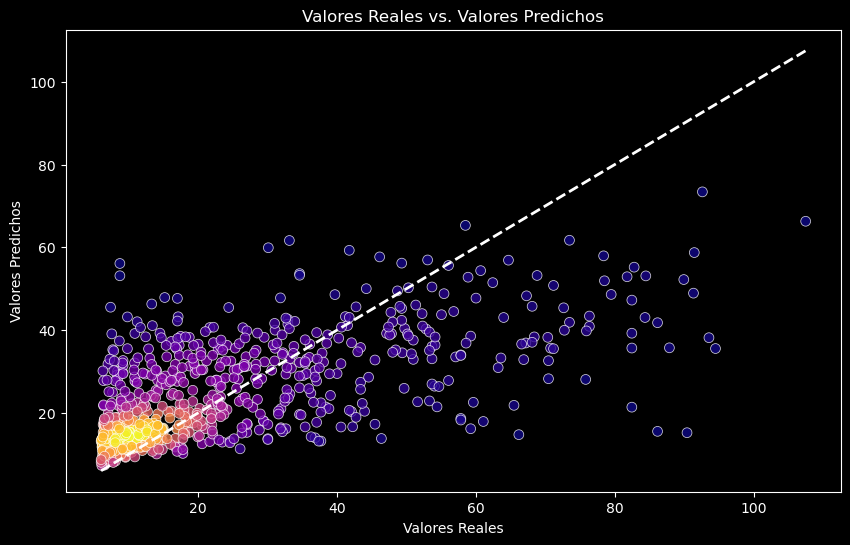

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Calcular la densidad de puntos
xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

# Crear un gráfico de dispersión con color basado en la densidad de puntos
plt.figure(figsize=(10, 6), facecolor='black')
scatter = plt.scatter(y_test, y_pred, c=z, s=50, cmap='plasma', edgecolor='white', alpha=0.8, linewidth=0.55)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'w--', lw=2)  # Línea de referencia en blanco
plt.xlabel('Valores Reales', color='white')
plt.ylabel('Valores Predichos', color='white')
plt.title('Valores Reales vs. Valores Predichos', color='white')

# Cambiar el color de los ejes y las etiquetas de los ticks
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().xaxis.label.set_color('white')
plt.gca().yaxis.label.set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')

# Cambiar el color del fondo del gráfico
plt.gca().set_facecolor('black')

# Guardar el gráfico
plt.savefig('real_vs_predicho2.png', facecolor='black')

# Mostrar el gráfico
plt.show()


        Feature  Importance
5            CH    0.178014
16    elevation    0.105374
17        slope    0.079717
7          NDBI    0.060333
2            B2    0.057285
8          NDVI    0.056385
14  VV_minus_VH    0.053173
1           B12    0.052129
0           B11    0.049817
6         MNDWI    0.049206
3            B3    0.048703
4            B4    0.046442
10           VH    0.042841
11           VV    0.029751
13    VV_div_VH    0.028158
9           RVI    0.024556
12  VV_VH_div_2    0.019414
15   VV_plus_VH    0.018703


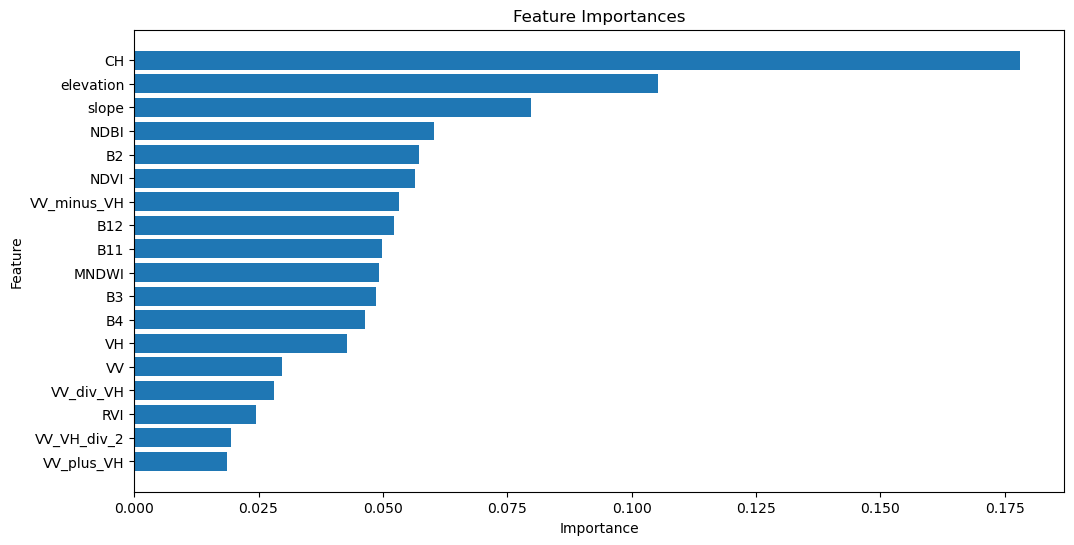

In [65]:
import matplotlib.pyplot as plt
# Obtener la importancia de las características
feature_importances = best_rf.feature_importances_

# Crear un DataFrame para organizar las importancias de las características
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar el DataFrame por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias de las características
print(feature_importances_df)

# Graficar las importancias de las características
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [91]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf, feature_names,output_mode='regression')
# print the first tree to see the result
# print(trees[0])

In [32]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)
# ee_classifier.getInfo()

In [92]:
user_id = 'users/facuboladerasgee'
# specify asset id where to save trees
# be sure to change  to your ee user name
asset_id = user_id + "/Rf_Gee_nepal"
asset_id
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

EEException: Request had insufficient authentication scopes.

In [ ]:
# # Exporta la imagen a Google Cloud Storage
# task = ee.batch.Export.image.toCloudStorage(
#     image=image,
#     description='Sentinel-2_export',
#     bucket='your_bucket_name',  # Reemplaza con el nombre de tu bucket
#     fileNamePrefix='sentinel-2_export',
#     scale=30,
#     region=region,
#     maxPixels=1e13  # Ajusta el límite de píxeles si es necesario
# )

# # Inicia la tarea de exportación
# task.start()

# print('Export task started. Check the GCS bucket for the exported files.')